## Randomized Benchmarking


This code is referenced from the following link:
- guide doc: https://forest-benchmarking.readthedocs.io/en/latest/examples/randomized_benchmarking.html
- github: https://github.com/rigetti/forest-benchmarking
- basic circuit: https://github.com/rigetti/pyquil
It is from rigetti.

This will talk about Randomized Benchmarking, interleaved RB and unitarity RB.

## Motivation and Background

RB通常用于在量子计算中表征门的平均性能。它在特定的门集上，对于量子比特具备扩展性，并且在SPAM（state preparation 和 measurement ）noise 具备鲁棒性。在程序中估计的 RB decay parameter 与理想的 average gate error 相关，虽然这个相关程序存在一定的条件（门的噪声变化层度不大，有具体的数学推导bound）。特别要注意的是，估计的门误差不是我们 QPU 的本机门集上平均的门误差（1-保真度）。当我们在下面说门错误时，我们指的是平均克利福德门错误。

该协议的主要思想是采用随机门序列，其中序列的理想复合操作是 identity。为了产生这样一个深度为 m+1 的序列，序列中前 m 个门中的每一个都是从 Clifford 组中均匀随机挑选的。使用群组合和逆属性，最后一个门被唯一地确定为 Clifford 元素，它反转前 m 个门的组合。如需说明，请参阅逻辑随机基准测试附录 A1 中的片段 (https://arxiv.org/pdf/1702.03688.pdf)。


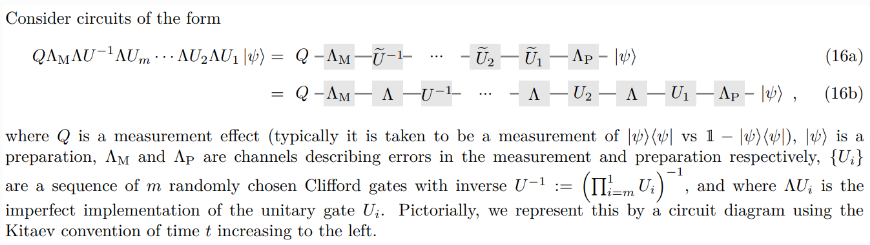

在有噪声的情况下，实际的$[U^{-1}, U_m, U_{m-1}, \dots, U_2, U_1]$，都受到$\Lambda$的噪声影响，并且存在态制备噪声$\Lambda_P$和测量噪声$\Lambda_M$，因此电路不是一个identity 操作。最终在执行序列后测量初始状态的结果 'survival probability' 为 `<1`。在估计完许多随d递增深度的随机序列后，我们能够拟合一个指数参数，如下所示：
$$A_0 p^d + B_0$$

由于对 Clifford 序列进行平均，可以有效地平均任何噪声通道$\Lambda$为去极化通道，因此我们得到了这种相对简单的形式 ；这个成立是因为Clifford group满足unitary 2-design(https://en.wikipedia.org/wiki/Quantum_t-design).

下面我们保存了 2q RB 数据图。每个数据点都是针对特定深度的单个序列估计的生存概率。拟合参数$A_0$ = amplitude, $p$ = decay, $B_0$ = baseline，在图下方的变量部分中报告：


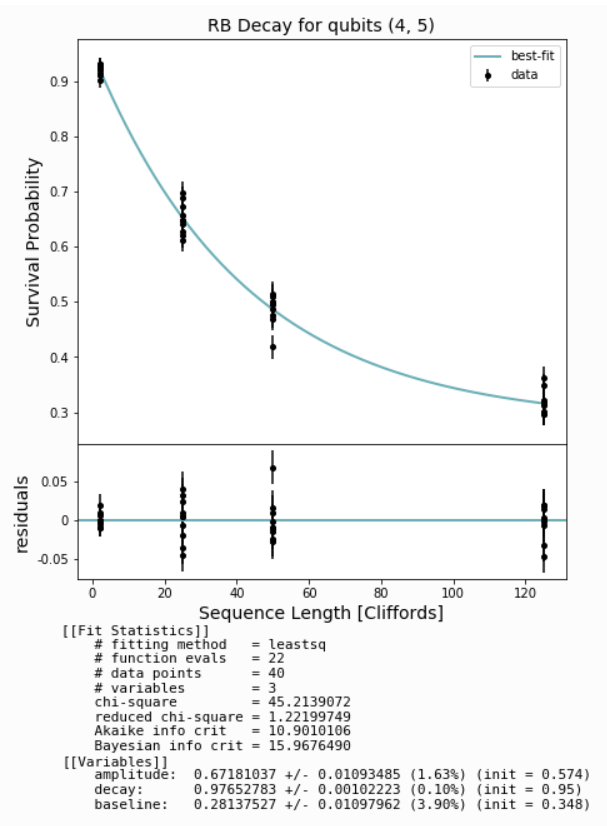

根据该拟合估计的参数$p$ 是 RB "decay"，它可能与平均门误差$r$相关
$$r = 1 - p - (1 - p) / \textrm{dim}$$

该过程的简要总结如下：
- 选择一些您预计 the survival probability 会逐渐衰减的深度，即深度逐渐增大
- 为每个深度生成许多随机序列
- 对于每个序列，通过 shots次 进行匹配输出与输入状态得到最终的分数，用来估计'survival probability' 。在这里，我们使用 ObservablesExperiment 框架来估计observable的期望值，从中我们可以计算'survival probability'。
- 将指数衰减模型拟合到估计的'survival probability'。
- 从拟合中提取衰减参数并转换为'average gate error'

请注意，RB 的解释是一个活跃的研究领域；参见下述内容，了解更多：
1. Wallman, Joel J. “Randomized Benchmarking with Gate-Dependent Noise.” Quantum, vol. 2, Jan. 2018, p. 47. arXiv.org, https://doi.org/10.22331/q-2018-01-29-47.
2. Proctor, Timothy, et al. “What Randomized Benchmarking Actually Measures.” Physical Review Letters, vol. 119, no. 13, Sept. 2017, p. 130502. arXiv.org, https://doi.org/10.1103/PhysRevLett.119.130502.

以下参考文献是有关 RB 协议的一般详细信息的起点：
1. Magesan, Easwar, et al. “Scalable and Robust Randomized Benchmarking of Quantum Processes.” Physical Review Letters, vol. 106, no. 18, May 2011, p. 180504. APS, https://doi.org/10.1103/PhysRevLett.106.180504.
2. Knill, E., et al. “Randomized Benchmarking of Quantum Gates.” Physical Review A, vol. 77, no. 1, Jan. 2008, p. 012307. arXiv.org, https://doi.org/10.1103/PhysRevA.77.012307.
3. Emerson, Joseph, et al. “Scalable Noise Estimation with Random Unitary Operators.” Journal of Optics B: Quantum and Semiclassical Optics, vol. 7, no. 10, Oct. 2005, pp. S347–52. arXiv.org, https://doi.org/10.1088/1464-4266/7/10/021.

## A simple single qubit example



我们将首先从 randomized_benchmarking.py 模块导入必要的方法，并设置一个演示量子计算机对象来表征，以及一个将生成 Clifford 序列的基准测试对象。

由于我们的演示使用量子虚拟机 (QVM)，因此您将需要一个 qvm 服务器。此外，我们目前依赖基准测试对象来生成 Clifford 序列，这需要 quilc 服务器。

如果没有安装相应的包，请安装：
```python
# pip install pyquil
# pip install numpy scipy
# pip install forest-benchmarking
```

In [1]:
# Needs in terminal:
# 根据Readme安装相应的环境即可。
# $ quilc -S
# $ qvm -S

import numpy as np

from forest.benchmarking.randomized_benchmarking import (generate_rb_sequence,
                                                         generate_rb_experiments, acquire_rb_data,
                                                        get_stats_by_qubit_group, fit_rb_results)

In [2]:
from pyquil.api import get_qc, BenchmarkConnection
qc = get_qc("9q-square-noisy-qvm")
bm = BenchmarkConnection()

### Create a single sequence
首先，我们可以在量子位 0 上生成 5 个 Clifford 门的单个序列进行检查。 （请注意，我们不必实际单独调用它来创建典型的实验）


In [3]:
# the results are stochastic and can be seeded with random_seed = #
sequence = generate_rb_sequence(bm, qubits=[0], depth=5)
for gate in sequence:
    print(gate) # each 'gate' is a separate pyquil Program

RZ(-pi/2) 0
RX(pi/2) 0

RX(pi/2) 0
RZ(-pi) 0

RX(-pi/2) 0
RZ(pi/2) 0

RX(-pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0

RZ(-pi) 0
RZ(-pi) 0



### Generate a single qubit RB experiment

现在让我们开始对单个量子位进行完整的实验。对于RB协议，我们需要生成许多不同深度的序列，并且需要对每个序列进行多次测量。

我们使用 ObservablesExperiment 框架，包含部分 Forest.benchmarking ，来估计运行完一个sequence的 observable $Z$的期望 $E[Z]$。

the survival probability 将是$E[Z]+1/2$。（在这个映射中，如果$E[Z]$接近1，那么Survival Probability就接近1，表示量子比特在计算基态的概率很高。如果$E[Z]$接近-1，Survival Probability就接近0，表示量子比特更有可能处于计算基态的相反状态。当$E[Z]$为0时，Survival Probability为1/2，表示量子比特处于计算基态和相反状态的概率相等。）

由于我们将使用相同的实验生成进行 "simultaneous" rb 实验，因此我们需要将我们的量子位指定为属于孤立的单量子位组。

In [4]:
qubit_groups = [(2,)] # characterize the 1q gates on qubit 2
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence

experiments_1q = generate_rb_experiments(bm, qubit_groups, depths)
print(experiments_1q[0])  

# 显示正在生成的整体序列
# 我们将把量子位 2 初始化到零状态并测量 the Z observable。

RX(-pi) 2; RX(-pi) 2
0: Z+_2→(1+0j)*Z2


第一个元素表示Clifford电路。

第二个元素显示为 ExperimentSetting[Z+_2→(1+0j)*Z2]。 ExperimentSetting 中的符号编码有关准备和测量的信息。应理解为“prepare”→“measure”。

因此，这个特定设置准备的编码 Z+_0 告诉我们，这个设置将准备 Z 的 + 本征态，即$|+\rangle$。此外，程序在此状态下运行后，我们将测量通过observable $X$ 在qubit2上，(1+0j) 只是一个乘法系数，在这种情况下 1。该系数将自动被纳入estimate_observables对相应可观察输出的期望和std_err的估计中。



0: Z+_2→(1+0j)*Z2，表示经过该变换之后，依旧没进行变换，相当于作用了identity gate。

In [9]:
len(experiments_1q[0])

1

### Acquire data
我们可以立即获取这些实验的数据。
下述中，每个sequence，我们都运行了500次，打印了显示序列 0 上每个observable的平均估计，目前只有一个可观察值，因此我们得到一个长度为 1 的列表。

经过电路之后，Z+_2→(1+0j)*Z2: 0.956 +- 0.013119756095293847，实际值为0.956 +- 0.013119756095293847。


In [6]:
num_shots = 500
# run the sequences on the qc object initialized above
results_1q = acquire_rb_data(qc, experiments_1q, num_shots, show_progress_bar=True)
print(results_1q[0])
# shows the estimates for each observable on sequence 0
# for now there's only one observable so we get a list of length 1

100%|██████████| 40/40 [00:55<00:00,  1.40s/it]

[ExperimentResult[Z+_2→(1+0j)*Z2: 0.94 +- 0.015257784898208521]]


In [7]:
print(len(results_1q))

40


### Analyze and plot
我们可以从每个 ExperimentResult 中解压结果并将其传递到拟合中。

In [8]:
# in this case it is simple to unpack the results--there is one result per sequence
expectations = [[res[0].expectation] for res in results_1q]
std_errs = [[res[0].std_err] for res in results_1q]

# 一种方便的方法，这对于更复杂的实验特别有帮助，本质上是将上述数据存储在每个qubit group的字典中。
# [(2,)]，是python中的字典取值，得到一个字典。
stats_q2 = get_stats_by_qubit_group(qubit_groups, results_1q)[(2,)]

# demonstrate equivalence
np.testing.assert_array_equal(expectations, stats_q2['expectation'])
np.testing.assert_array_equal(std_errs, stats_q2['std_err'])

# fit the exponential decay model
fit_1q = fit_rb_results(depths, expectations, std_errs, num_shots)

In [9]:
# get_stats_by_qubit_group(qubit_groups, results_1q)

In [10]:
# fit_1q

该拟合包含 rb 衰减的估计，从中我们可以得到门误差。 我们还可以画一个图


这里可能会存在错误，因为中导入了'color': TEAL
FIT_PLOT_KWS = {
    'data_kws': {'color': 'black', 'marker': 'o', 'markersize': 4.0},
    'init_kws': {'color': TEAL, 'alpha': 0.4, 'linestyle': '--'},
    'fit_kws': {'alpha': 1.0, 'linewidth': 2.0},
    'numpoints': 1000
}
# 'color': TEAL,

d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2074: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2195: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9958371010566154


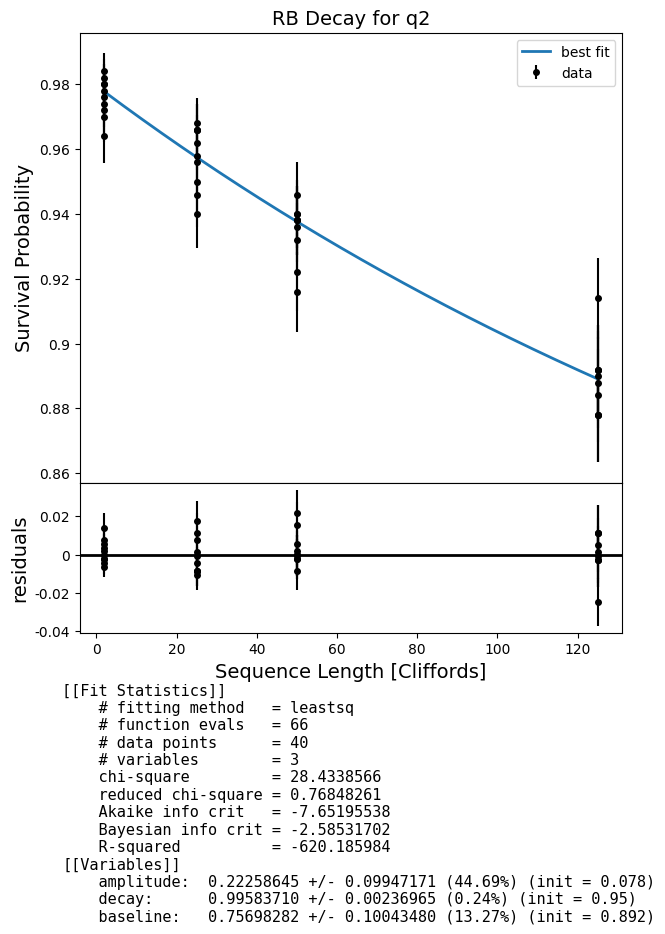

In [11]:
from forest.benchmarking.plotting import plot_figure_for_fit

fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title='RB Decay for q2')
rb_decay_q2 = fit_1q.params['decay'].value
# ax.axhline(0, color='k')
print(rb_decay_q2)

## Simultaneous RB


运行Simultaneous实验和多量子位实验遵循相同的工作流程。

在这里，我们将演示 1q、2q 同时实验。 “Simultaneous”必须在真实的 QPU 上进行某种限定——门的物理动作不能保证按照 quil 程序指定的顺序发生（quil 程序实际上只指定因果关系）。 

此外，一个门序列可以在另一个“Simultaneous”序列结束之前终止。 仅当所有门都已执行时才会进行测量。

### Generate the simultaneous experiment


In [12]:
qubit_groups = [(2,), (4,5)] # characterize the 1q gates on qubit 2, and the 2q Cliffords on (4,5)
num_sequences_per_depth = 10
# specify the depth of each simultaneous sequence
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  

experiments_simult = generate_rb_experiments(bm, qubit_groups, depths)
print(experiments_simult[0])  
# note that this sequence consists of only 1q gates on qubit 2 
# while qubits 4 and 5 should have some CZ gates

RX(-pi/2) 2; RZ(-pi/2) 2; CZ 4 5; RZ(-pi/2) 4; RX(pi/2) 4; ... 12 instrs not shown ...; CZ 4 5; RZ(-pi/2) 5; RX(-pi/2) 5; RZ(-pi/2) 4; RX(-pi/2) 4
0: Z+_2→(1+0j)*Z2, Z+_4 * Z+_5→(1+0j)*Z5, Z+_4 * Z+_5→(1+0j)*Z4, Z+_4 * Z+_5→(1+0j)*Z4Z5


### Acquire data


在 QVM 上收集此数据可能需要几分钟的时间


In [13]:
num_shots = 500
# run the sequences on the qc object initialized above
results_simult = acquire_rb_data(qc, experiments_simult, num_shots, show_progress_bar=True)
print(results_simult[0])
# shows the estimates for each observable on sequence 0
# there is one observable on q2 and three on qubits (4,5)

100%|██████████| 40/40 [02:39<00:00,  3.98s/it]

[ExperimentResult[Z+_2→(1+0j)*Z2: 0.96 +- 0.01252198067399882], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z5: 0.904 +- 0.019119832635250758], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z4: 0.916 +- 0.017941237415518473], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z4Z5: 0.836 +- 0.024539926650257123]]


### Analyze and plot


WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


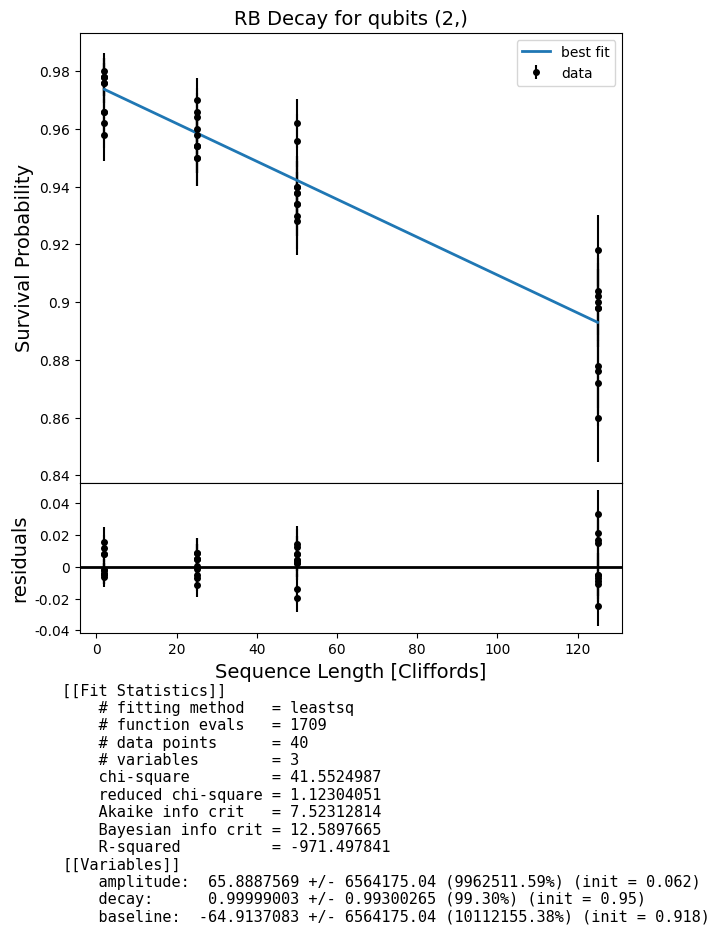

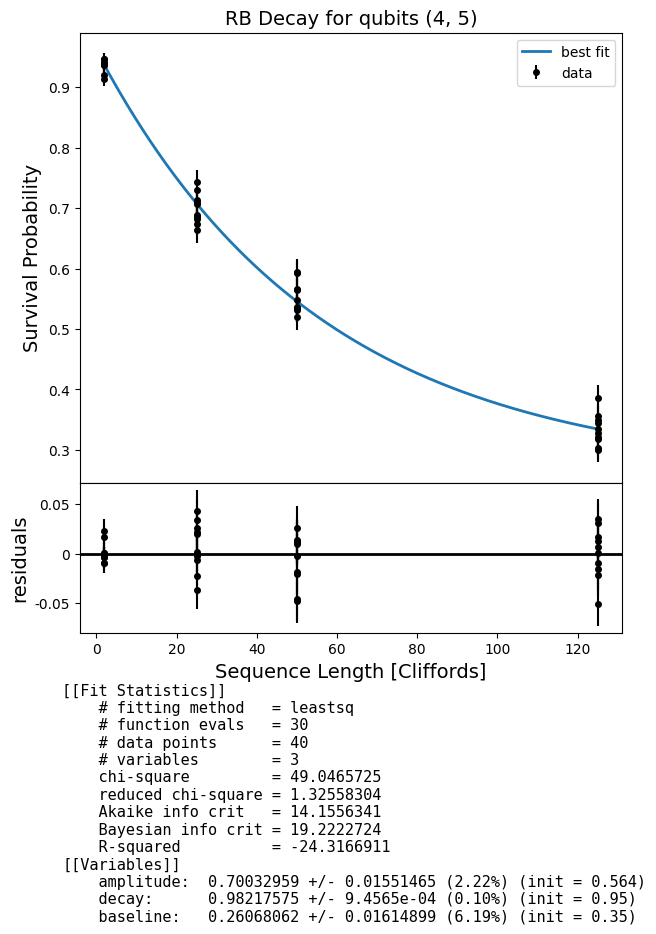

In [14]:
stats_simult = get_stats_by_qubit_group(qubit_groups, results_simult)

fits = []
for qubits, stats in stats_simult.items():
    exps = stats['expectation']
    std_errs = stats['std_err']
    # fit the exponential decay model
    fit = fit_rb_results(depths, exps, std_errs, num_shots)
    fits.append(fit)
    fig, ax = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title=f'RB Decay for qubits {qubits}')

一般来说，我们预计在真实的 QPU 上运行同步 RB 实验会因串扰等影响而导致较小的衰减值；除非您创建一个捕获此类效应的噪声模型，否则这不会出现在 QVM 上。


## Advanced usage


### Modifying the Clifford sequences


如果您希望使用 RB 模块中提供的基本功能，但希望修改每个序列中的各个 Clifford 元素，例如，我们将实验生成分为两个步骤。 通过替换为逻辑量子位上的逻辑运算。

In [15]:
from forest.benchmarking.randomized_benchmarking import generate_rb_experiment_sequences
# similar to generate_rb_experiments we need a benchmarker and the depths for each sequence. 
# unlike generate_rb_experiments we only specify a group of qubits rather than a list of simultaneous qubit groups
qubits = (2,3)
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence

sequences_23 = generate_rb_experiment_sequences(bm, qubits, depths)
print(sequences_23[0])
# here we see that each sequence is given with the division into Clifford gates rather than as a single program
# if we wished, we could modify these sequences at a Clifford-gate level.

[<pyquil.quil.Program object at 0x0000020D7EDCAA90>, <pyquil.quil.Program object at 0x0000020D7E6B1820>]


In [16]:
from forest.benchmarking.randomized_benchmarking import group_sequences_into_parallel_experiments
# now we can collect our modified sequences into an experiment
expt_2q_non_simult = group_sequences_into_parallel_experiments([sequences_23], [qubits])
print(f'A 2q experiment on qubits {qubits}')
print(expt_2q_non_simult[0])

# this generalizes to simultaneous experiments
sequences_01 = generate_rb_experiment_sequences(bm, (0,1), depths)
expt_2q_simult = group_sequences_into_parallel_experiments([sequences_23, sequences_01], [qubits, (0,1)])
print('\nA simultaneous 2q experiment.')
print(expt_2q_simult[0])

A 2q experiment on qubits (2, 3)
RZ(-pi) 3; RX(-pi) 3; RZ(pi/2) 2; RX(pi/2) 2; RZ(-pi) 3; RX(-pi) 3; RX(-pi/2) 2; RZ(-pi/2) 2
0: Z+_2 * Z+_3→(1+0j)*Z3, Z+_2 * Z+_3→(1+0j)*Z2, Z+_2 * Z+_3→(1+0j)*Z2Z3

A simultaneous 2q experiment.
RZ(-pi) 3; RX(-pi) 3; RZ(pi/2) 2; RX(pi/2) 2; CZ 0 1; ... 14 instrs not shown ...; RX(pi/2) 1; RX(pi/2) 0; CZ 0 1; RZ(-pi/2) 0; RX(-pi/2) 0
0: Z+_2 * Z+_3→(1+0j)*Z3, Z+_2 * Z+_3→(1+0j)*Z2, Z+_2 * Z+_3→(1+0j)*Z2Z3, Z+_0 * Z+_1→(1+0j)*Z1, Z+_0 * Z+_1→(1+0j)*Z0, Z+_0 * Z+_1→(1+0j)*Z0Z1


### Very fast RB by few point measurements


如果我们有 p=0.9 的先验信息（例如通过提前运行 RB），我们可能希望监视作为时间函数的衰减，以查看我们的实验是否随时间漂移。
A fisher information analysis 显示给定样本的最佳序列长度
$$
d^{\rm opt} \sim - \frac{1}{\ln p}.
$$
假设栅极随时间漂移，并且之前已经通过重复 RB 来表征drift 。然后我们可以想象以对应于分布 $\langle p \rangle \pm {\rm stdev}(p)$ 的序列长度进行采样。 


In [17]:
qubit_groups = [(2,)] # characterize the 1q gates on qubit 2
num_sequences_per_depth = 10
depths = [d for d in [6, 10, 19] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence
print(depths)
experiments_1q = generate_rb_experiments(bm, qubit_groups, depths)  

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ExperimentResult[Z+_2→(1+0j)*Z2: 0.972 +- 0.01050866309289626]]


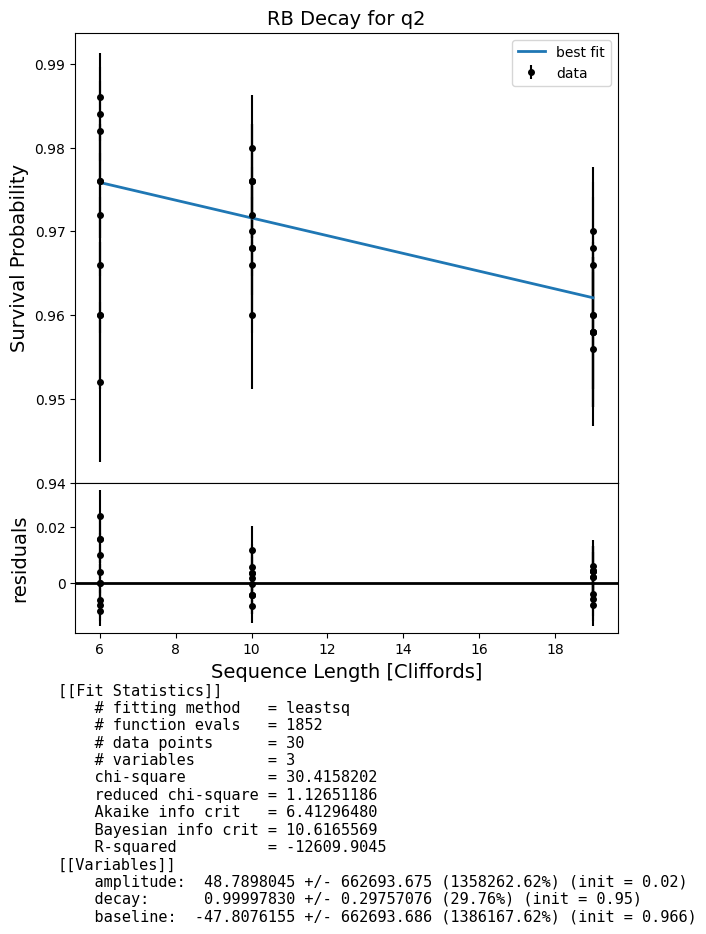

In [18]:
num_shots = 500
# run the sequences on the qc object initialized above
results_1q = acquire_rb_data(qc, experiments_1q, num_shots, show_progress_bar=True)
print(results_1q[0])
# in this case it is simple to unpack the results--there is one result per sequence
expectations = [[res[0].expectation] for res in results_1q]
std_errs = [[res[0].std_err] for res in results_1q]
# fit the exponential decay model
fit_1q = fit_rb_results(depths, expectations, std_errs, num_shots)
fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title='RB Decay for q2')